In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import IPython
import IPython.display
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-10 16:25:49.765643: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 16:25:49.791930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 16:25:49.791978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
WINDOW_WIDTHS = np.arange(10, 100, 2)
SHIFT_WIDTH = 40
JUMP_D = 10
NB_FEATURES = 2

In [4]:
@tf.keras.utils.register_keras_serializable('JSC')
class Jaccard(tf.keras.Metric):
    def __init__(self, name='JSC', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_tp'
        )
        self.false_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fp'
        )
        self.false_negatives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fn'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(tf.math.round(y_pred), "bool")

        tp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        tp_values = tf.keras.ops.cast(tp_values, self.dtype)
        
        fp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        fp_values = tf.keras.ops.cast(fp_values, self.dtype)
        
        fn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        fn_values = tf.keras.ops.cast(fn_values, self.dtype)
        
        tn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        tn_values = tf.keras.ops.cast(tn_values, self.dtype)

        self.true_positives.assign(self.true_positives + tf.keras.ops.sum(tp_values))
        self.false_positives.assign(self.false_positives + tf.keras.ops.sum(fp_values))
        self.false_negatives.assign(self.false_negatives + tf.keras.ops.sum(fn_values))

    def result(self):
        return self.true_positives / (self.true_positives + self.false_positives + self.false_negatives)

In [5]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [6]:
def make_signal(x_pos, y_pos, win_widths):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        for checkpoint in range(int(win_width/2), len(x_pos) - int(win_width/2)):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])

            ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

            std_xs1 = np.std(xs1)
            std_xs2 = np.std(xs2)
            std_ys1 = np.std(ys1)
            std_ys2 = np.std(ys2)

            surface_xs1 = abs(np.sum(xs1)) / win_width
            surface_xs2 = abs(np.sum(xs2)) / win_width
            surface_ys1 = abs(np.sum(ys1)) / win_width
            surface_ys2 = abs(np.sum(ys2)) / win_width


            xs1 = np.cumsum(abs(xs1)) #* surface_xs1
            xs2 = np.cumsum(abs(xs2)) #* surface_xs2
            ys1 = np.cumsum(abs(ys1)) #* surface_ys1
            ys2 = np.cumsum(abs(ys2)) #* surface_ys2


            xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
            xs1 = xs1 / xs_max_val
            xs2 = xs2 / xs_max_val
            xs1 = xs1 / win_width
            xs2 = xs2 / win_width

            ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
            ys1 = ys1 / ys_max_val
            ys2 = ys2 / ys_max_val
            ys1 = ys1 / win_width 
            ys2 = ys2 / win_width

            vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                       * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                             * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))

        vals = np.concatenate((np.ones(int(win_width/2)) * -1, vals))
        vals = np.concatenate((vals, np.ones(int(win_width/2)) * -1))
        vals = np.array(vals)
        all_vals.append(vals)
    
    all_vals = np.array(all_vals) + 1e-7
    normalized_vals = all_vals.copy()
    for i in range(len(normalized_vals)):
            normalized_vals[i] = normalized_vals[i] / np.max(normalized_vals[i])
    return all_vals, normalized_vals

In [7]:
def compress_signals(signals):
    compressed_signal = []
    nb_signal = signals.shape[1]
    
    for row in signals.transpose():
        nb_activ_window = np.sum(row >= 0)
        if nb_activ_window != 0:
            comp = np.sum(row[row >= 0])
        else:
            comp = 1e-7
        compressed_signal.append(comp)
    compressed_signal = (np.array(compressed_signal) - float(np.min(compressed_signal))) / np.max(compressed_signal)
    return compressed_signal

In [8]:
def slice_data(signal_seq, jump_d=10):
    slice_d = []
    indice = []
    for i in range(SHIFT_WIDTH//2, signal_seq.shape[0] - SHIFT_WIDTH//2, jump_d):
        crop = signal_seq[i - SHIFT_WIDTH//2: i + SHIFT_WIDTH//2]
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice)

In [9]:
def merge_close_points(changepoints, signal, seuil=5):
    seq_sums = []
    val_orders = np.argsort(signal[changepoints])[::-1]
    
    filtered_cps = []
    all_cps_range = set()
    for cp in changepoints[val_orders]:
        regis_cp_range = np.arange(-seuil + cp, seuil + cp)
        if len(set(regis_cp_range) & all_cps_range) == 0:
            filtered_cps.append(cp)
            all_cps_range.update(regis_cp_range)
    filtered_cps = np.array(filtered_cps)
    return filtered_cps

In [16]:
def ana_cp_predict(model, x, y, win_widths, jump_d):
    cps = []
    signal, norm_signal = make_signal(x, y, win_widths)
    comp_signal = compress_signals(signal)
    feat1 = np.mean(comp_signal)**2 / np.std(comp_signal)**2
    feat2 = np.max(signal, axis=1).mean()
    input_signals, indice = slice_data(comp_signal, jump_d=jump_d)
    input_signals = np.array(input_signals).reshape(-1, 1, SHIFT_WIDTH, 1)
    input_features = np.array([feat1, feat2] * input_signals.shape[0]).reshape(-1, NB_FEATURES)

    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, input_features], verbose=0).flatten()
        #cps = indice[np.round(pred) >= 1]
        cps = indice[pred >= 0.9]  
    if len(cps) == 0:
        return cps
        
    """
    reg_inputs = []
    for cp in cps:
        reg_inputs.append(signal_seq[:, cp - (SHIFT_WIDTH//2): cp + (SHIFT_WIDTH//2)])
    reg_inputs = np.array(reg_inputs).reshape(-1, activ_nb_win*2, SHIFT_WIDTH, 1)
    reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()
    cps = np.round(cps + reg_outputs).astype(int)
    """
    cps = merge_close_points(cps, comp_signal, seuil=40)

    return np.sort(cps)

# Produce results

In [11]:
classification_model = tf.keras.models.load_model(f'./models/cls_model_{SHIFT_WIDTH}_2.keras')
#classification_model.summary()
#regression_model = tf.keras.models.load_model('regression_model_0.keras')
#regression_model.summary()

2024-05-10 16:25:58.007083: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 16:25:58.007164: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 16:25:58.007200: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 16:25:58.133111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 16:25:58.133162: I external/local_xla/xla/stream_executor

In [12]:
import os
public_data_path = 'public_data_validation_v1/' # make sure the folder has this name or change it
path_results = 'res_valid/'
if not os.path.exists(path_results):
    os.makedirs(path_results)

N_EXP = 13
N_FOVS = 30

In [11]:
from andi_datasets.utils_videos import import_tiff_video
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

video = import_tiff_video(public_data_path+'track_1/exp_0/videos_fov_1.tiff')

[  1  10  21  24  25  26  33  37  38  41 255]


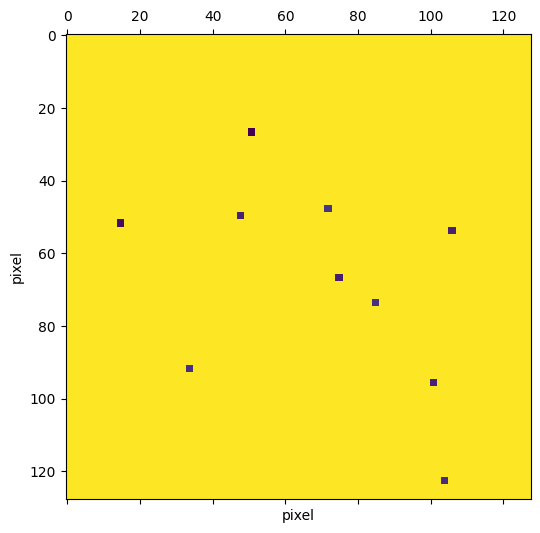

In [12]:
print(np.unique(video[0]))
plt.matshow(video[0])
plt.xlabel('pixel');plt.ylabel('pixel');

In [13]:
for track in [1,2]:
    
    # Create the folder of the track if it does not exists
    path_track = path_results + f'track_{track}/'
    if not os.path.exists(path_track):
        os.makedirs(path_track)
        
    for exp in range(N_EXP):
        # Create the folder of the experiment if it does not exits
        path_exp = path_track+f'exp_{exp}/'
        if not os.path.exists(path_exp):
            os.makedirs(path_exp)
        file_name = path_exp + 'ensemble_labels.txt'
        
        with open(file_name, 'a') as f:
            # Save the model (random) and the number of states (2 in this case)
            model_name = np.random.choice(datasets_phenom().avail_models_name, size = 1)[0]
            f.write(f'model: {model_name}; num_state: {2} \n')

            # Create some dummy data for 2 states. This means 2 columns
            # and 5 rows
            data = np.random.rand(5, 2)
            
            data[-1,:] /= data[-1,:].sum()

            # Save the data in the corresponding ensemble file
            np.savetxt(f, data, delimiter = ';')

In [ ]:
# Define the number of experiments and number of FOVS

for track in [2]:
    path_track = path_results + f'track_{track}/'
    for exp in range(N_EXP):
        path_exp = path_track + f'exp_{exp}/'
        for fov in range(N_FOVS):
            # We read the corresponding csv file from the public data and extract the indices of the trajectories:
            if track == 2:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
            else:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
            traj_idx = np.sort(df.traj_idx.unique())
            submission_file = path_exp + f'fov_{fov}.txt'

            with open(submission_file, 'w') as f:

                # Loop over each index
                for idx in traj_idx:

                    # Get the lenght of the trajectory
                    x = np.array(df[df.traj_idx == idx])[:, 2]
                    y = np.array(df[df.traj_idx == idx])[:, 3]
                    length_traj = df[df.traj_idx == idx].shape[0]


                    try:
                        cps = ana_cp_predict(classification_model, x, y, WINDOW_WIDTHS, JUMP_D)
                        cps = np.concatenate((cps, [length_traj])).astype(int)
                    except Exception as e:
                        cps = []

                    prediction_traj = [idx.astype(int)]
                    for k, alpha, state, cp in zip([99999999] * len(cps), [99999999] * len(cps),
                                                   [99999999] * len(cps), cps):
                        prediction_traj.append(k)
                        prediction_traj.append(alpha)
                        prediction_traj.append(state)
                        prediction_traj.append(cp)

                    formatted_numbers = ','.join(map(str, prediction_traj))
                    f.write(formatted_numbers + '\n')